In [ ]:
pip install yfinance

In [ ]:
# Import the libraries
import os
import random
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from numpy.linalg import cholesky
import pandas_datareader.data as web
from ipywidgets import interact, fixed, IntSlider

In [ ]:
# from datetime import datetime
# # Get the stock/portfolio starting and ending date
# stock_start_date = "2016-06-01"
# stock_end_date = "2020-06-01"

# # Get the stock data
# df = web.DataReader("ASIANPAINT.NS", data_source = "yahoo", start = stock_start_date, end = stock_end_date)

In [ ]:
# Create a function for the stock data
cached_data = {}
def stock_data(symbol, start = None, end = None, cached_data = cached_data):

    '''Convenience function to get cached data '''

    if not symbol in cached_data:
        cached_data[symbol] = yf.download(symbol)
        print(F"Loaded {symbol} num values = {len(cached_data[symbol])}")
    return cached_data[symbol]

In [ ]:
# Load the stock data 
tickers = ["ITC.NS", "ASIANPAINT.NS", "TCS.NS", "BAJFINANCE.NS", "LT.NS", "^NSEI"]
N = len(tickers)
historical  = pd.concat((stock_data(symbol)["Adj Close"] for symbol in tickers), axis = 1, keys = tickers).dropna(axis = 0)

[*********************100%***********************]  1 of 1 completed
Loaded ITC.NS num values = 6195
[*********************100%***********************]  1 of 1 completed
Loaded ASIANPAINT.NS num values = 4582
[*********************100%***********************]  1 of 1 completed
Loaded TCS.NS num values = 4044
[*********************100%***********************]  1 of 1 completed
Loaded BAJFINANCE.NS num values = 4581
[*********************100%***********************]  1 of 1 completed
Loaded LT.NS num values = 4589
[*********************100%***********************]  1 of 1 completed
Loaded ^NSEI num values = 3264


,ITC.NS,ASIANPAINT.NS,TCS.NS,BAJFINANCE.NS,LT.NS,^NSEI
Date,,,,,,
2007-09-17,39.217995,40.610584,160.298676,13.559645,433.765961,4494.649902
2007-09-18,39.087883,40.163864,161.069962,13.690742,438.428925,4546.200195
2007-09-19,40.627567,40.056480,164.379257,13.686947,447.034821,4732.350098
2007-09-20,42.091328,40.771660,161.005005,13.686947,460.320984,4747.549805
2007-09-21,41.397377,40.161720,163.535950,13.679322,466.540741,4837.549805


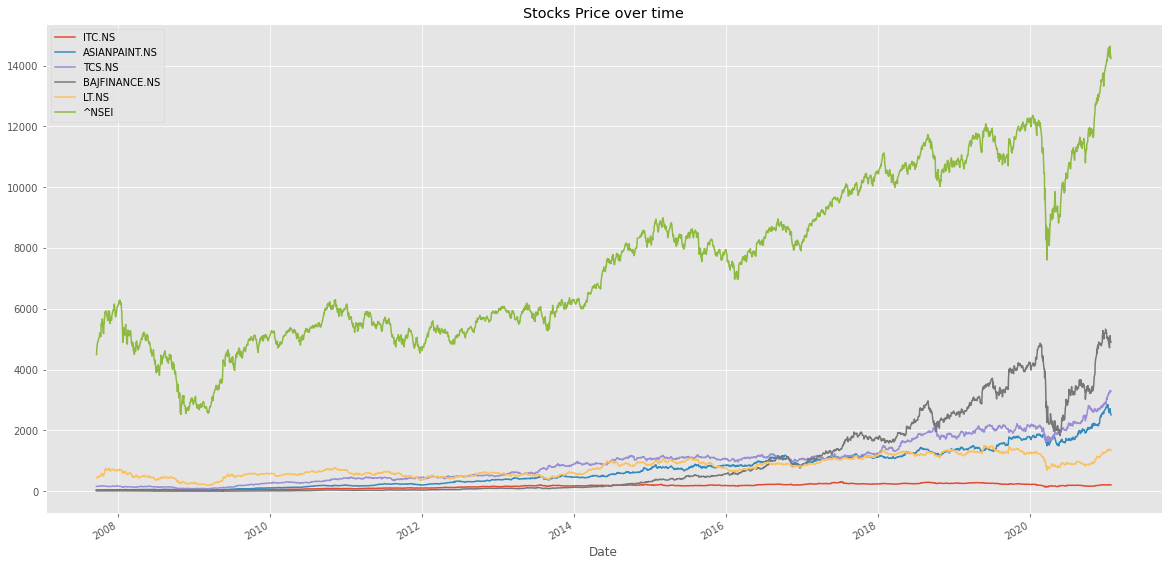

In [ ]:
# Plot the stock data and check the top 5
_ = (historical).plot(figsize = (20, 10), title = "Stocks Price over time")
historical.head(5)

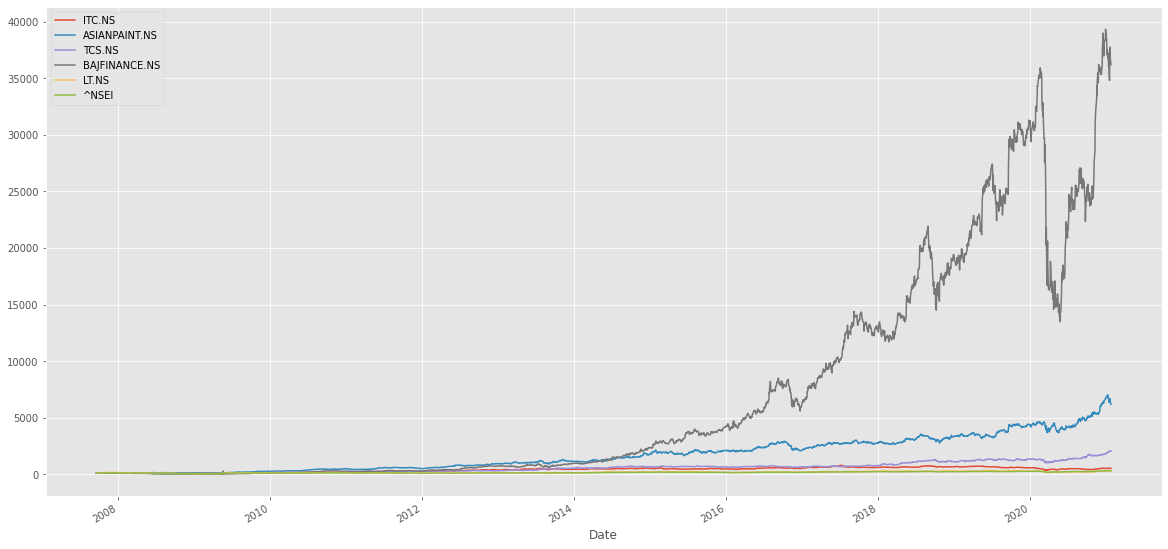

In [ ]:
# Plot the stock data with normalization to 100
(historical / historical.iloc[0] * 100).plot(figsize = (20, 10))

In [ ]:
# Calculate the daily simple return, daily pct change & volatility
returns = (historical/historical.iloc[0]).fillna(method = "backfill")

daily_pct_change = np.log(returns.pct_change() + 1)

vols = daily_pct_change.std() * np.sqrt(252)

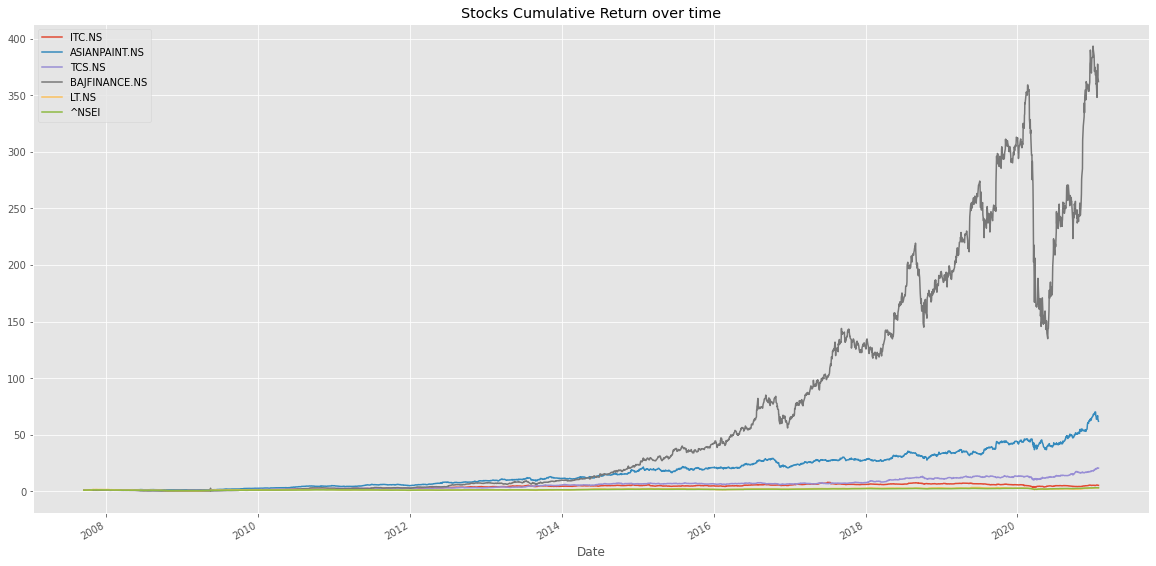

In [ ]:
# Plot the cumulative return
_ = returns.plot(figsize = (20, 10), title = "Stocks Cumulative Return over time")

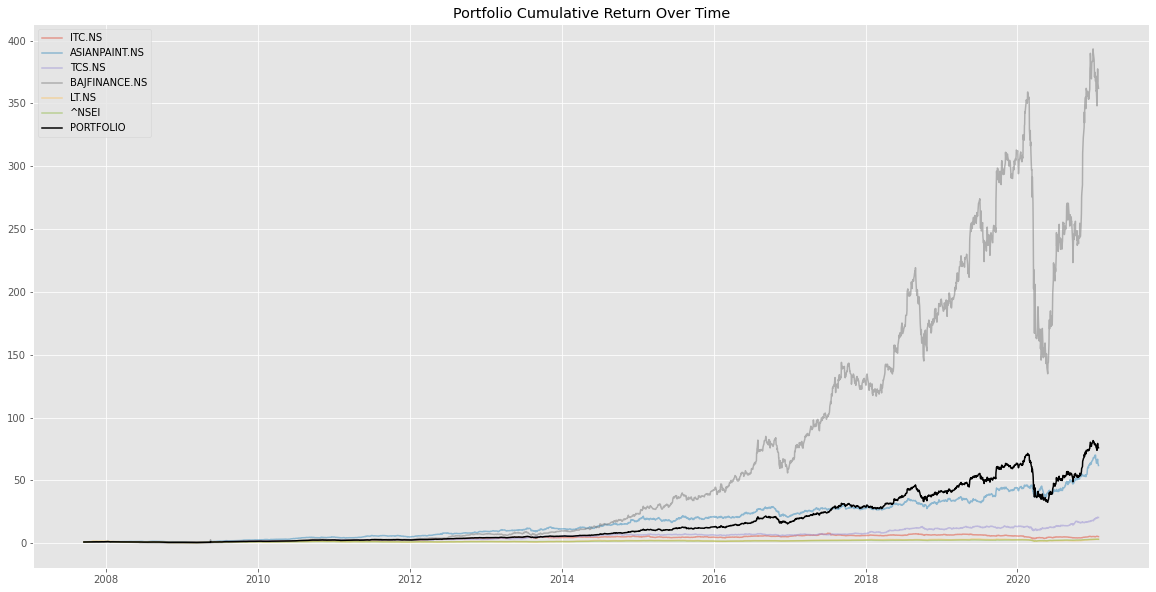

In [ ]:
# Create our equally weighted portfolio return series and plot the Price of our portfolio against the individual constituents
returns["PORTFOLIO"] = returns.iloc[:, 0:N].sum(axis = 1) / N

plt.figure(figsize = (20, 10))
lines = plt.plot(returns.drop("PORTFOLIO", axis = 1), alpha = 0.5)
plt.title("Portfolio Cumulative Return Over Time")
plt.plot(returns["PORTFOLIO"], color = "black", alpha = 1)
plt.legend(returns.columns)
plt.show()

In [ ]:
# Load the price of stock and get top 5 
tickers = ["ITC.NS", "ASIANPAINT.NS", "TCS.NS", "BAJFINANCE.NS", "LT.NS", "^NSEI"]
prices = [stock_data(symbol)["Adj Close"] for symbol in tickers]
prices = pd.concat((stock_data(symbol)["Adj Close"] for symbol in tickers), axis = 1, keys = tickers).dropna(axis = 0)
prices.tail(5)

,ITC.NS,ASIANPAINT.NS,TCS.NS,BAJFINANCE.NS,LT.NS,^NSEI
Date,,,,,,
2021-01-19,218.850006,2645.050049,3260.699951,4959.149902,1369.849976,14521.150391
2021-01-20,217.649994,2697.250000,3308.800049,4981.950195,1382.650024,14644.700195
2021-01-21,213.699997,2716.350098,3273.850098,5118.299805,1371.300049,14590.349609
2021-01-22,210.699997,2596.649902,3303.100098,4972.549805,1362.099976,14371.900391
2021-01-25,207.800003,2513.949951,3291.300049,4908.700195,1361.300049,14238.900391


In [ ]:
# Get the volatility
daily_pct_change = np.log(returns.pct_change() + 1)
vols = daily_pct_change.std() * np.sqrt(252) # Annual Volatility 
vols

ITC.NS           0.287405
ASIANPAINT.NS    0.288820
TCS.NS           0.316229
BAJFINANCE.NS    0.975817
LT.NS            0.353928
^NSEI            0.227717
PORTFOLIO        0.319876
dtype: float64

In [ ]:
# Create a function for diversification and backtesting
def diversicheck(symbols, start_day = 0, time_horizon = 365, **active):
    filtered = [symbol for symbol in symbols if active.get(symbol, True)]
    prices = pd.concat((stock_data(symbol)["Adj Close"] for symbol in filtered), axis = 1, keys = filtered).dropna(axis = 0)
    
    start_dates = prices.index[0] + datetime.timedelta(days = start_day)
    end_dates = start_dates + datetime.timedelta(days = time_horizon)
    
    prices = prices.loc[start_dates: end_dates]
    
    unit_pos = prices / prices.iloc[0,:]
    basket = unit_pos.sum(axis = 1) / unit_pos.shape[1]
    unit_pos.plot(figsize = (20,10), title = "Stocks Cumulative Return over time", alpha = 0.5)
    basket.plot(figsize = (20,10),legend = True)
    print(f"backtest from {start_dates} to {end_dates}")

In [ ]:
# Making an intractive model for the stocks in the portfolio
# cached_data = {}
port_stocks = ["ITC.NS", "ASIANPAINT.NS", "TCS.NS", "BAJFINANCE.NS", "LT.NS", "KOTAKBANK.NS", "^NSEI"] # Choose any from yahoo finance
active = dict(zip(port_stocks, [True] * len(port_stocks)))
_ = interact(diversicheck, symbols = fixed(port_stocks), start_day = IntSlider(min = 0, max = 252 * 15), time_horizon = IntSlider(min = 0, value = 365, max = 252 * 5), **active)

interactive(children=(IntSlider(value=0, description='start_day', max=3780), IntSlider(value=365, description=…

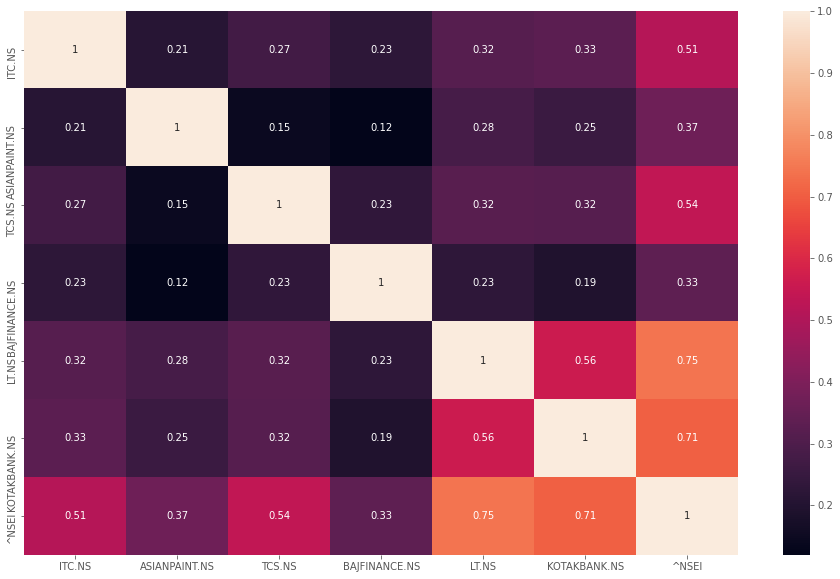

In [ ]:
# Plot a correlation heatmap for the returns
port_prices = pd.concat((stock_data(symbol)["Adj Close"] for symbol in port_stocks), axis = 1, keys = port_stocks).dropna(axis = 0)
port_returns = (port_prices.pct_change() + 1)[1:]
log_returns = np.log(port_returns)
corr = log_returns.corr()

fig, ax = plt.subplots(figsize = (16, 10)) 
sns.heatmap(corr, annot = True)

In [ ]:
# Calculate the average return
vols = log_returns.std() * np.sqrt(252)
avg_return = (port_returns - 1).mean()
avg_return

ITC.NS           0.000675
ASIANPAINT.NS    0.001431
TCS.NS           0.001125
BAJFINANCE.NS    0.004623
LT.NS            0.000600
KOTAKBANK.NS     0.000988
^NSEI            0.000456
dtype: float64

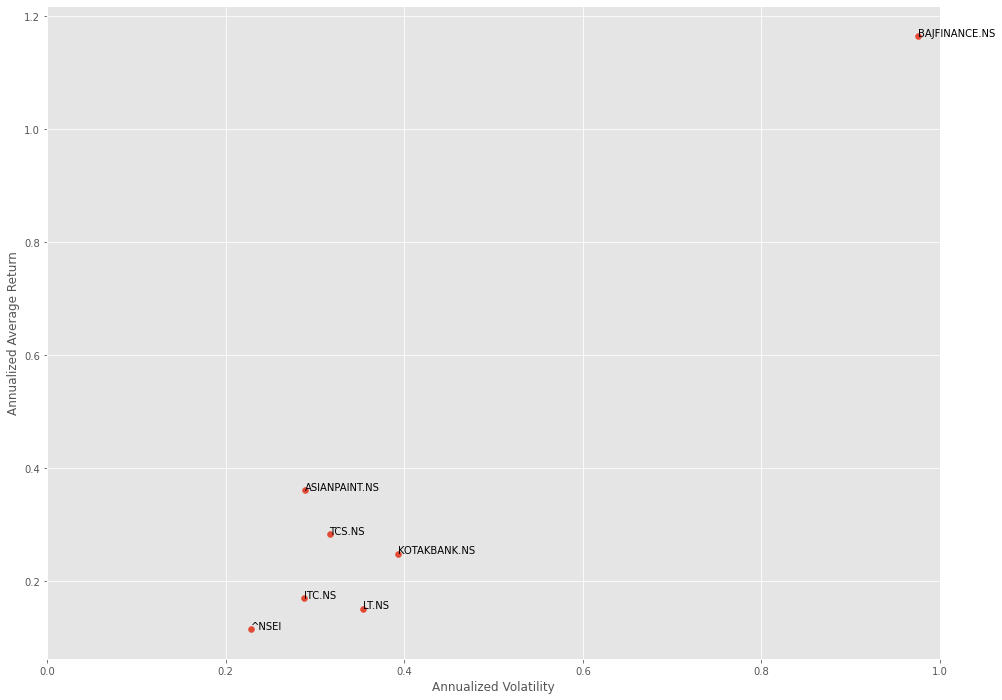

In [ ]:
# Plot the return and volatility
fig, ax = plt.subplots(figsize = (16, 12))
ax.scatter(vols, avg_return*252)
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Average Return")
ax.set_xlim(0, 1)
for i, txt in enumerate(port_stocks):
    ax.annotate(txt, xy = (vols[i], avg_return[i] * 252))

In [ ]:
# Bootstapping the model by applying monte carlo simulation
number_of_simulations = 1000
investment_horizon = 60
simulated = pd.DataFrame([(port_returns.iloc[random.choices(range(len(port_returns)), k = investment_horizon)]).mean(axis = 1).cumprod().values for x in range(number_of_simulations)]).T
simulated.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.999490,1.008845,1.034587,1.012759,0.997445,1.017192,1.006106,1.010283,0.992878,0.995549,1.000900,1.006408,0.987485,1.006041,0.980430,0.986672,1.005854,1.030597,0.990752,1.004602,1.022398,0.962584,0.999388,1.002121,0.991053,0.995173,1.008884,0.997819,1.005323,0.997441,1.009578,1.024054,0.986967,0.997725,0.988883,0.990400,1.001266,1.008733,1.013651,1.000127,...,0.878989,1.009430,1.001048,0.987110,1.010685,0.999160,0.996547,1.003031,0.983621,1.035032,1.011435,1.002396,0.991571,1.001798,1.007499,1.010024,0.994297,0.992878,1.007171,0.986716,0.997727,0.997589,0.988662,1.000696,0.985329,0.962337,1.000735,1.004378,0.982321,1.027982,0.996062,0.994848,1.004211,0.988837,1.008049,1.008351,0.985093,0.990938,0.981093,0.986098
1,1.006019,1.004023,1.027166,0.996913,0.999239,1.015811,1.022139,1.009483,0.998419,0.987413,1.006934,1.010510,1.015599,1.000910,0.980680,0.991748,1.011397,1.028211,0.987455,1.001084,1.017336,0.956742,1.003170,1.016142,0.994693,0.995249,1.004153,0.991327,1.028510,1.002512,1.006916,1.007853,0.985338,0.991518,0.986499,0.980184,1.014687,1.007637,1.008429,1.007860,...,0.871580,1.011912,1.003496,0.980905,1.003942,0.998530,0.998300,0.991965,0.990681,1.043721,1.002269,1.002884,1.003036,1.007538,1.011830,1.032484,0.990378,1.005754,0.997799,0.991832,1.000345,1.000182,0.984735,1.008668,0.978620,0.960023,0.995398,1.009481,0.987608,1.045073,1.006448,0.994847,0.955646,0.995030,1.010094,1.008664,0.984020,0.987516,0.973396,0.988561
2,1.007028,0.996764,1.032923,1.002396,0.988146,1.017659,1.017722,0.999071,1.009528,1.001659,1.003269,1.003235,1.008747,0.990133,0.983375,0.995211,1.016960,1.025399,0.981671,0.992045,1.023093,0.975117,1.017783,1.030753,0.988161,0.991746,0.983173,1.008370,1.008271,1.001893,1.011018,0.997234,0.994039,1.004909,0.988140,0.982261,1.005816,1.013467,1.014082,1.015298,...,0.860519,1.015208,1.023328,0.959469,1.009046,0.999326,1.003373,0.982204,0.996629,1.017059,0.997861,1.003638,1.013352,1.012830,1.017752,1.021599,0.989474,1.000195,0.969137,0.997309,1.005090,1.004869,0.971359,1.020017,0.990275,0.962012,1.004325,1.004469,0.995449,1.045961,1.020374,1.006147,0.957782,0.992768,1.014858,1.028210,0.974811,0.992637,0.986423,0.986262
3,1.008436,1.017710,1.033426,1.006892,0.994432,1.027194,1.020715,0.995776,0.993696,0.999340,1.008054,1.002682,1.021342,1.002184,0.998047,1.008421,1.020577,1.016013,0.989041,0.986025,1.018119,0.978284,1.028249,1.028192,1.006161,0.990609,0.975437,1.011094,1.008719,0.995156,1.009916,0.984862,0.998640,0.992634,0.969842,1.024610,1.001706,1.009079,1.021805,1.015296,...,0.837172,1.021713,1.019294,0.970558,1.015166,1.002822,1.008473,0.994304,0.998022,0.996410,1.014828,1.008945,1.024766,0.966554,1.010681,1.023585,0.989826,1.003979,1.001202,1.019034,0.991364,0.985237,0.958430,1.010051,0.969585,0.956490,1.006007,0.985224,0.993877,1.047940,1.013089,1.009304,0.964685,0.988487,1.023720,1.021130,0.960829,0.999633,0.982514,0.998535
4,0.999438,1.019636,1.029169,1.003360,0.989449,1.016352,1.011848,0.997887,0.996315,0.994867,0.990718,1.004343,1.020492,1.044137,0.985399,1.002509,1.021761,1.016721,1.005644,0.981625,1.016633,0.962814,1.036002,1.022192,0.999504,0.991114,0.973065,1.013189,1.016719,1.003092,1.015220,0.972028,0.979585,0.993860,0.957770,1.027093,1.018029,1.021636,0.987673,1.013521,...,0.858297,1.001711,1.016677,0.974370,1.012714,0.999499,1.005371,1.000781,0.989198,0.996584,1.026432,1.017136,1.014771,0.964344,1.008659,1.052424,0.988574,0.995458,1.005924,1.019011,0.986546,0.983568,0.965351,1.000456,0.981535,0.944129,0.976269,0.979865,0.950545,1.047903,1.012830,1.001123,0.962654,0.973357,1.065775,1.027889,0.961528,0.973891,0.950592,1.005078


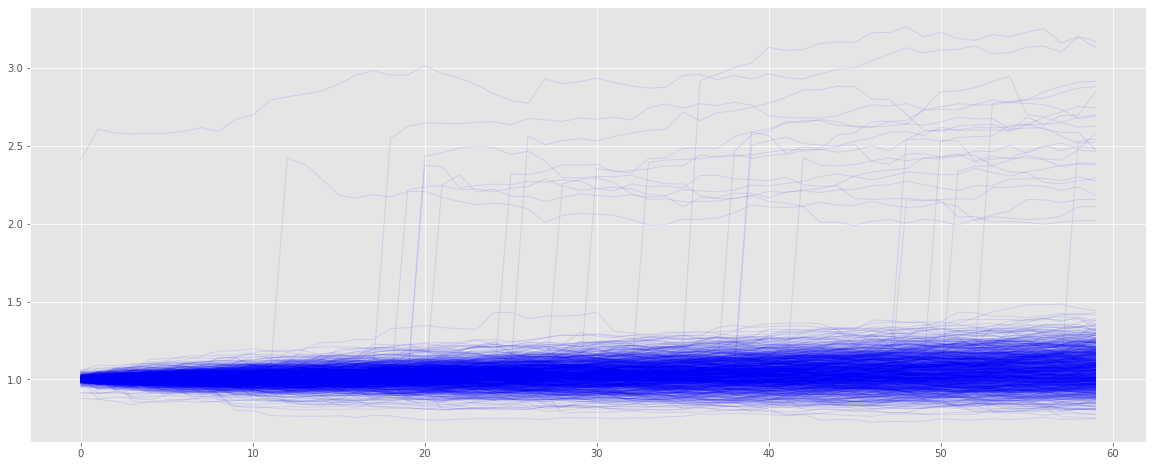

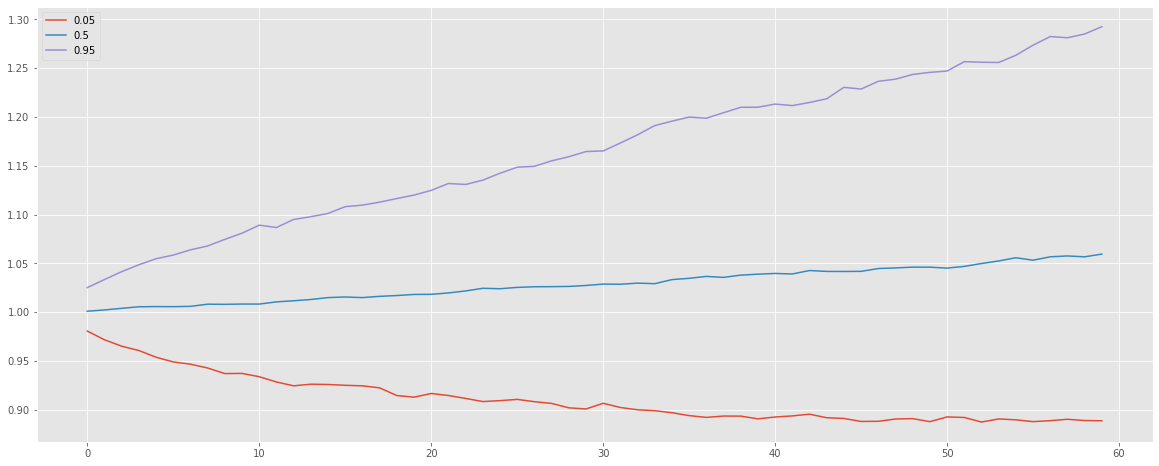

In [ ]:
# Let's plot the simulation
simulated.plot(legend = False, linewidth = 1, alpha = 0.1, color = "blue", figsize = (20, 8))
simulated.quantile([0.05, 0.50, 0.95], axis = 1).T.plot(figsize=(20, 8))